In [59]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython import display
display.set_matplotlib_formats('svg')

C:\Users\Pablo\AppData\Local\Temp\ipykernel_7052\3599945686.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [13]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [14]:
data = torch.tensor(iris.drop('species', axis=1).values, dtype=torch.float32)

# transform species to numeric labels
labels = iris['species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2}).values
labels = torch.tensor(labels, dtype=torch.long) # torch long is used for classification labels

In [23]:
def create_model(n_hidden_neurons, hidden_layer=True, learning_rate=0.01):

    # model architecture
    if hidden_layer:
        model = nn.Sequential(
            nn.Linear(4, n_hidden_neurons), 
            nn.ReLU(),       
            nn.Linear(n_hidden_neurons, n_hidden_neurons),
            nn.ReLU(),
            nn.Linear(n_hidden_neurons, 3)
            # nn.Softmax(dim=1) # not needed since we will use CrossEntropyLoss which applies softmax internally
        )
    else:
        model = nn.Sequential(
            nn.Linear(4, n_hidden_neurons), 
            nn.ReLU(),       
            nn.Linear(n_hidden_neurons, 3)
        )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    return model, loss_fn, optimizer

def train(model, loss_fn, optimizer, data, labels, epochs=1000):

    for epoch in range(epochs):
        
        # forward pass
        y_pred_logits = model(data)
        loss = loss_fn(y_pred_logits, labels)

        # compute accuracy
        y_pred = torch.argmax(y_pred_logits, dim=1)

        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute final accuracy
    accuracy = (y_pred == labels).float().mean().item()

    return accuracy

In [27]:
num_epochs = 150
learning_rate = 0.01
num_hidden_neurons = np.arange(1, 129)
accuracies_no_hidden_layer = []
accuracies_with_hidden_layer = []

for n in num_hidden_neurons:
    model, loss_fn, optimizer = create_model(n, hidden_layer=False, learning_rate=learning_rate)
    accuracy = train(model, loss_fn, optimizer, data, labels, epochs=num_epochs)
    accuracies_no_hidden_layer.append(accuracy)

for n in num_hidden_neurons:
    model, loss_fn, optimizer = create_model(n, hidden_layer=True, learning_rate=learning_rate)
    accuracy = train(model, loss_fn, optimizer, data, labels, epochs=num_epochs)
    accuracies_with_hidden_layer.append(accuracy)

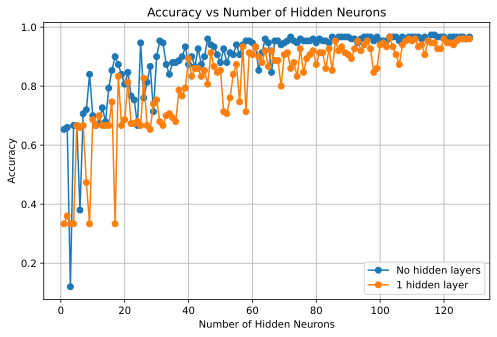

In [29]:
# Plot accuracy vs number of hidden neurons
plt.figure(figsize=(8, 5))
plt.plot(num_hidden_neurons, accuracies_no_hidden_layer, marker='o', label='No hidden layers')
plt.plot(num_hidden_neurons, accuracies_with_hidden_layer, marker='o', label='1 hidden layer')
plt.title('Accuracy vs Number of Hidden Neurons')
plt.xlabel('Number of Hidden Neurons')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# We can observe that the models with higher number of neurons have a better performance,
# since they add more complexity and degrees of freedom to the model, allowing it to learn 
# more complex patterns in the data.

In [ ]:
# check wide vs deep
widenet = nn.Sequential(
    nn.Linear(2, 4), # hidden layer with 4 neurons
    nn.Linear(4, 3)  # output layer with 3 neurons (for 3 classes)
)

deepnet = nn.Sequential(
    nn.Linear(2, 2), # hidden layer with 2 neurons
    nn.Linear(2, 2), # hidden layer with 2 neurons
    nn.Linear(2, 3)  # output layer with 3 neurons (for 3 classes)
)

In [53]:
num_nodes_widenet = 0
for param in widenet.named_parameters():
    if "bias" in param[0]:
        num_nodes_widenet += len(param[1])

num_nodes_deepnet = 0
for param in deepnet.named_parameters():
    if "bias" in param[0]:
        num_nodes_deepnet += len(param[1])

num_total_params_widenet = sum(p.numel() for p in widenet.parameters())
num_total_params_deepnet = sum(p.numel() for p in deepnet.parameters())

print(f"Widenet - Total parameters: {num_total_params_widenet}, nodes: {num_nodes_widenet}")
print(f"Deepnet - Total parameters: {num_total_params_deepnet}, nodes: {num_nodes_deepnet}")

Widenet - Total parameters: 27, nodes: 7
Deepnet - Total parameters: 21, nodes: 7


In [57]:
# simpple way to print out the model info
summary(widenet, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              12
            Linear-2                 [-1, 1, 3]              15
Total params: 27
Trainable params: 27
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [58]:
summary(deepnet, input_size=(1, 2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 2]               6
            Linear-2                 [-1, 1, 2]               6
            Linear-3                 [-1, 1, 3]               9
Total params: 21
Trainable params: 21
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
